# QCoDeS Example with Tektronix TPS2012 channels

In [1]:
%matplotlib nbagg
import binascii
import logging

import matplotlib.pyplot as plt
import qcodes as qc
import numpy as np
import qcodes.instrument_drivers.tektronix.TPS2012_channels as tektps

from time import time, sleep

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

User schema at /Users/jhn/qcodesrc_schema.json not found.User settings won't be validated


We now instantiate the new TPS2012 with channels

In [2]:
tps = tektps.TPS2012WithChannels('TPS1', 'ASRL2::INSTR')

Connected to: TEKTRONIX TPS 2012B (serial:0, firmware:CF:91.1CT FV:v11.10) in 1.67s


In [3]:
# For good measures, one may clear out old messages
tps.clear_message_queue()

We can now iterate over all channels. Here we prepare the curvedata

In [8]:
tps.force_trigger()
sleep(10*tps.horizontal_scale.get())
for channel in tps.channels:
    channel.curvedata.prepare_curvedata()

Readable snapshot will include all the channels

In [9]:
tps.print_readable_snapshot(update=True)

TPS1:
	parameter         value
--------------------------------------------------------------------------------
IDN                :	{'firmware': 'CF:91.1CT FV:v11.10', 'serial': '0', 'mode...
data_source        :	CH2
 
horizontal_scale   :	2.5e-05 (s)
timeout            :	20 (s)
trigger_edge_slope :	RISE
 
trigger_level      :	1.52E0
 (V)
trigger_source     :	CH2
 
trigger_type       :	EDGE
 
TPS1_ch1:
	parameter value
--------------------------------------------------------------------------------
curvedata :	None (V )
position  :	2 (div)
scale     :	0.05 (V/div)
state     :	ON 
TPS1_ch2:
	parameter value
--------------------------------------------------------------------------------
curvedata :	None (V )
position  :	-3 (div)
scale     :	1 (V/div)
state     :	ON 


## SETTING UP AN ACQUISITION
The driver supports basic setting of scales and triggers.

In this example, we want to look at a 10 kHz sine, 100 mVpp with a -50 mV offset.

The sine is on channel **1**, while the sync (0 V to 3 V square wave) signal from the function generator is on channel **2**.

In [10]:
# we don't want to see the ref. signal, only the sine
tps.ch1.state('ON')
tps.ch2.state('OFF')

# horizontal
tps.horizontal_scale.set(10e-6)
# channel 1
tps.ch1.scale.set(50e-3)  # V/div
tps.ch1.position.set(2)  # divisions
# channel 2
tps.ch2.scale.set(1)
tps.ch2.position.set(-3)
# trigger
tps.trigger_type.set('EDGE')
tps.trigger_source.set('CH2')
tps.trigger_level.set(1.5)

## ACQUIRING THE CURVES FROM THE OSCILLOSCOPE
There is a simple command to get two arrays for the horizontal and vertical data.

Because this is early beta version you must currently call `prepare_curvedata` on each channel just before reading a trace from the channel. This is a limitation in the current dataset/loop /parameter of qcodes. You should also ensure that the scope has been triggered at these settings before calling set_set_points or you will get inconsitent data. 

In this example notebook we use force_trigger to ensure that we always have data when setting the set_points

With channel support we can capture both channels in a single command

In [11]:
tps.force_trigger()
sleep(10*tps.horizontal_scale.get())
tps.ch1.curvedata.prepare_curvedata()
tps.ch2.curvedata.prepare_curvedata()
data1 = qc.Measure(tps.channels.curvedata).run()

/Users/jhn/src/Qcodes/qcodes/instrument/parameter.py:634: UserWarning: MultiParameters do not fully support set at this time.
  warnings.warn('MultiParameters do not fully support set '


DataSet:
   location = 'data/2017-06-13/#008_{name}_13-05-56'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | Time_set           | Time               | (2500,)
   Measured | TPS1_ch1_curvedata | TPS1_ch1_curvedata | (2500,)
   Measured | TPS1_ch2_curvedata | TPS1_ch2_curvedata | (2500,)
acquired at 2017-06-13 13:06:09


<IPython.core.display.Javascript object>


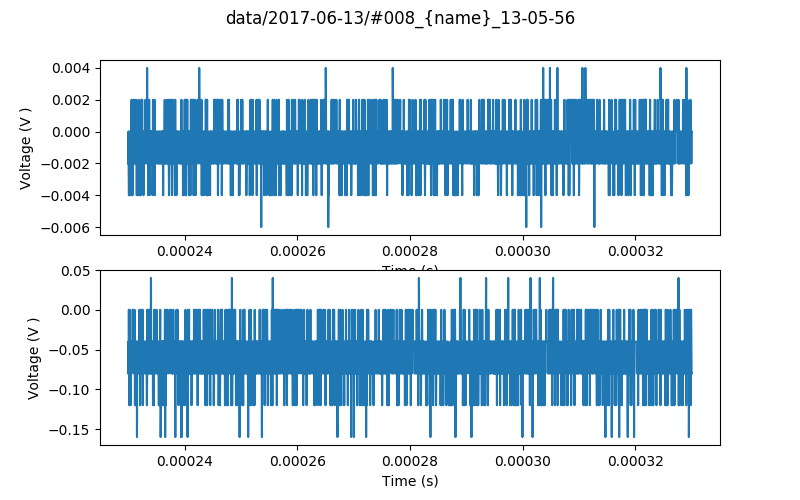

In [12]:
plot = qc.MatPlot(subplots=(2, 1))
plot.add(data1.TPS1_ch1_curvedata, subplot=1)
plot.add(data1.TPS1_ch2_curvedata, subplot=2)

We can also get the channels individually from the channels list

In [13]:
tps.force_trigger()
sleep(10*tps.horizontal_scale.get())
tps.ch1.curvedata.prepare_curvedata()
tps.ch2.curvedata.prepare_curvedata()
data2 = qc.Measure(tps.channels[1].curvedata, tps.channels[2].curvedata).run()

DataSet:
   location = 'data/2017-06-13/#009_{name}_13-07-47'
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Measured | TPS1_ch1_curvedata | curvedata    | (2500,)
   Measured | TPS1_ch2_curvedata | curvedata    | (2500,)
acquired at 2017-06-13 13:08:01


The channels are also accesable by name as they are added individually

In [14]:
tps.force_trigger()
sleep(11*tps.horizontal_scale.get_latest())
tps.ch1.curvedata.prepare_curvedata()
tps.ch2.curvedata.prepare_curvedata()
data3 = qc.Measure(tps.ch1.curvedata, tps.ch2.curvedata).run()

DataSet:
   location = 'data/2017-06-13/#010_{name}_13-08-53'
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Measured | TPS1_ch1_curvedata | curvedata    | (2500,)
   Measured | TPS1_ch2_curvedata | curvedata    | (2500,)
acquired at 2017-06-13 13:09:06


And via named parameters within the channel list

In [15]:
tps.force_trigger()
sleep(11*tps.horizontal_scale.get_latest())
tps.ch1.curvedata.prepare_curvedata()
tps.ch2.curvedata.prepare_curvedata()
data4 = qc.Measure(tps.channels.ch1.curvedata, tps.channels.ch2.curvedata).run()

DataSet:
   location = 'data/2017-06-13/#011_{name}_13-09-56'
   <Type>   | <array_id>         | <array.name> | <array.shape>
   Measured | TPS1_ch1_curvedata | curvedata    | (2500,)
   Measured | TPS1_ch2_curvedata | curvedata    | (2500,)
acquired at 2017-06-13 13:10:09


Change horisontal scale and remember to call `prepare_curvedata` to update the setpoint array

In [16]:
tps.horizontal_scale.set(25e-6)

In [20]:
tps.force_trigger()
sleep(11*tps.horizontal_scale.get_latest())
tps.ch1.curvedata.prepare_curvedata()
tps.ch2.curvedata.prepare_curvedata()
data5 = qc.Measure(tps.channels.curvedata).run()

/Users/jhn/src/Qcodes/qcodes/instrument/parameter.py:634: UserWarning: MultiParameters do not fully support set at this time.
  warnings.warn('MultiParameters do not fully support set '


DataSet:
   location = 'data/2017-06-13/#014_{name}_13-13-49'
   <Type>   | <array_id>         | <array.name>       | <array.shape>
   Setpoint | Time_set           | Time               | (2500,)
   Measured | TPS1_ch1_curvedata | TPS1_ch1_curvedata | (2500,)
   Measured | TPS1_ch2_curvedata | TPS1_ch2_curvedata | (2500,)
acquired at 2017-06-13 13:14:02


<IPython.core.display.Javascript object>


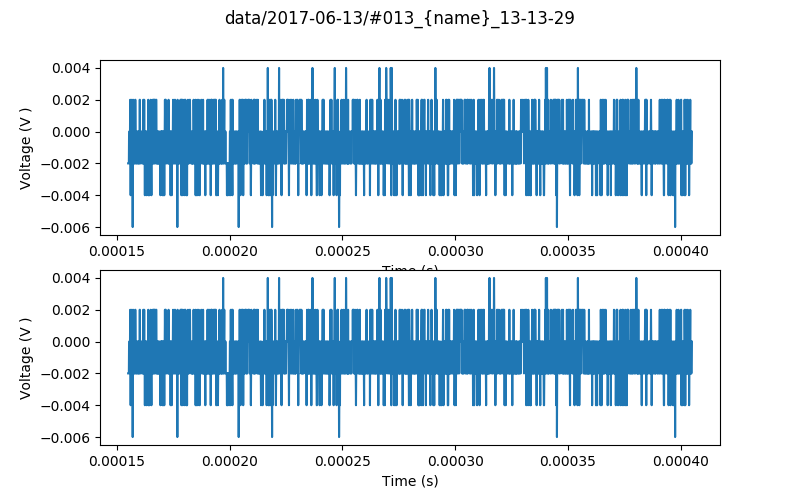

In [19]:
plot = qc.MatPlot(subplots=(2, 1))
plot.add(data5.TPS1_ch1_curvedata, subplot=1)
plot.add(data5.TPS1_ch1_curvedata, subplot=2)